# Wait for another task

## Introduction
In WorkGraph, tasks are generally launched when their input tasks are completed. However, there may be scenarios where you need to delay the execution of a task until another unrelated task is complete. This can occur, for example, when the task's input depends on data dynamically populated in the `context`, and you must ensure this data is ready before proceeding.

This tutorial will guide you through using the `task.waiting_on` attribute in Task to manage such dependencies effectively.

**Note**: for cross-WorkGraph dependencies, i.e. you want to wait for a task from another WorkGraph, you can use the `monitor` task, please refer to the [Monitor Task](../built-in/monitor.ipynb) tutorial.


#### Adding Tasks to Waiting List
To ensure `task3` does not start before `task1` and `task2` are completed, you can add these tasks to its `waiting_on` list.

Here's how to add tasks to the `waiting_on` list:

```python
# You can use the name of the task, or the task object itself
# assuming task1 and task2 are already defined
task3.waiting_on.add(["task1", task2])
```

#### Removing Tasks from Waiting List
You can remove them from the `waiting_on` list as follows:

```python
task3.waiting_on.remove(["task1", "task2"])
```

#### Clearing the Waiting List
If you need to remove all waiting dependencies from `task3`, you can clear the entire `waiting_on` list:

```python
task3.waiting_on.clear()
```

## Example
Here we create two `add` tasks and one `sum` task. The `sum` task will wait for the two `add` tasks to finish.

In [1]:
from aiida_workgraph import task
from aiida.orm import Float
from aiida import load_profile
load_profile()

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

# define sum task
@task.calcfunction()
def sum(**datas):
    total = 0
    for data in datas.values():
        total += data.value
    return Float(total)


In [2]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("test_wait")
add1 = wg.add_task(add, name="add1", x=1, y=1)
add1.set_context({"data.add1": "result"})
add2 = wg.add_task(add, name="add2", x=2, y=2)
add2.set_context({"data.add2": "result"})
# let sum task wait for add1 and add2, and the `data` in the context is ready
sum3 = wg.add_task(sum, name="sum1", datas="{{data}}")
sum3.waiting_on.add(["add1", "add2"])
wg.submit(wait=True)

WorkGraph process created, PK: 107107


<WorkChainNode: uuid: 0818adef-71c3-4e8c-858c-339ea8b6f4a2 (pk: 107107) (aiida.workflows:workgraph.engine)>

### Check status and results


In [3]:
print("State of WorkGraph         : {}".format(wg.state))
print('Result of sum1: {}'.format(wg.tasks["sum1"].node.outputs.result.value))

State of WorkGraph         : FINISHED
Result of sum1: 6.0


Generate node graph from the AiiDA process:

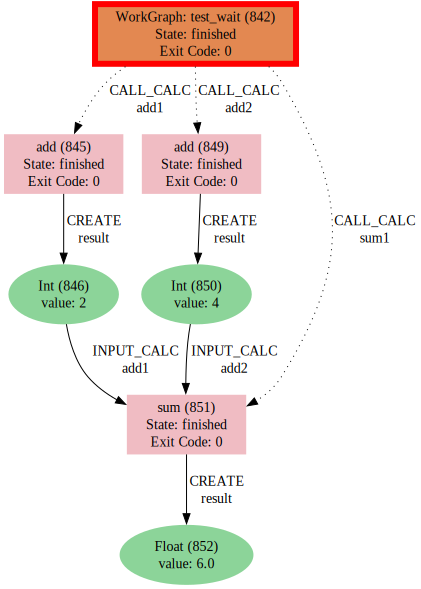

In [5]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)